# Statistical Gridding of Data from The Ocean Data Platform

In this notebook we will download ocean temperature measurements from the seas around Scandinavia and create a map of the average summer ocean temperatures, at 10m depth, for the year 2018. This includes:
- Downloading data fron the Ocean Data Platform
- Interpolating each temperature profile to get the temperature at 10m depth
- Create a gridded map of the mean summer temperature using four different teqhniques

In [51]:
from odp_sdk import ODPClient
from CastFunctions import *
import cmocean
import warnings
warnings.filterwarnings("ignore")


In [52]:
client = ODPClient(api_key='OWNhYmQyMWMtNGIyMS00ZDdhLTg1NWUtYTdmMzUxMmJlOTQ1', 
                       project="odp", client_name="odp")


In [53]:
df=client.casts(longitude=[-25,35],
                latitude=[50,80],
                timespan=['2018-06-01','2018-08-31'],
                n_threads=35)

Locating available casts..
-> 9147 casts found
-> 1159275 data rows downloaded in 184.20s


In [54]:
df=df[(df['Temperature_WODflag']==0) & (df.z<50)][['externalId','lon','lat','z','datetime','Temperature']].dropna()

In [55]:
df.head(10)

,externalId,lon,lat,z,datetime,Temperature
0,cast_wod_3_2018_32727_18913246,1.997,56.19,7.0,2018-08-28,16.43
1,cast_wod_3_2018_32727_18913246,1.997,56.19,9.0,2018-08-28,16.43
2,cast_wod_3_2018_32727_18913246,1.997,56.19,10.0,2018-08-28,16.43
3,cast_wod_3_2018_32727_18913246,1.997,56.19,11.0,2018-08-28,16.43
4,cast_wod_3_2018_32727_18913246,1.997,56.19,12.0,2018-08-28,16.43
5,cast_wod_3_2018_32727_18913246,1.997,56.19,13.0,2018-08-28,16.43
6,cast_wod_3_2018_32727_18913246,1.997,56.19,14.0,2018-08-28,16.43
7,cast_wod_3_2018_32727_18913246,1.997,56.19,15.0,2018-08-28,16.43
8,cast_wod_3_2018_32727_18913246,1.997,56.19,16.0,2018-08-28,16.43
9,cast_wod_3_2018_32727_18913246,1.997,56.19,17.0,2018-08-28,16.43


## Interpolate casts to desired depths

In [56]:
df_surf=interpolate_casts_to_z(df,'Temperature',[0,10,20])

In [57]:
df_surf.dropna(inplace=True)
df_surf=df_surf[df_surf.Temperature>-1]
df_surf.describe()

,lon,lat,z,Temperature
count,21795.000000,21795.000000,21795.000000,21795.000000
mean,2.548769,59.571030,10.283551,12.985659
std,9.985343,7.209735,8.010408,4.556012
min,-24.936000,50.038000,0.000000,-0.950000
25%,-4.640000,54.966320,0.000000,10.170000
50%,1.421500,57.450000,10.000000,13.770000
75%,9.913431,61.180250,20.000000,16.270000
max,34.002500,79.999664,20.000000,25.802584


## Surface temperature measurements

In [60]:
df_surf=df_surf[(df_surf.datetime>'2018-06-01')& (df_surf.datetime<'2018-08-31') &(df_surf.z==10)]

Text(0.5, 1.0, 'Ocean Temperatures at 10m Depth')

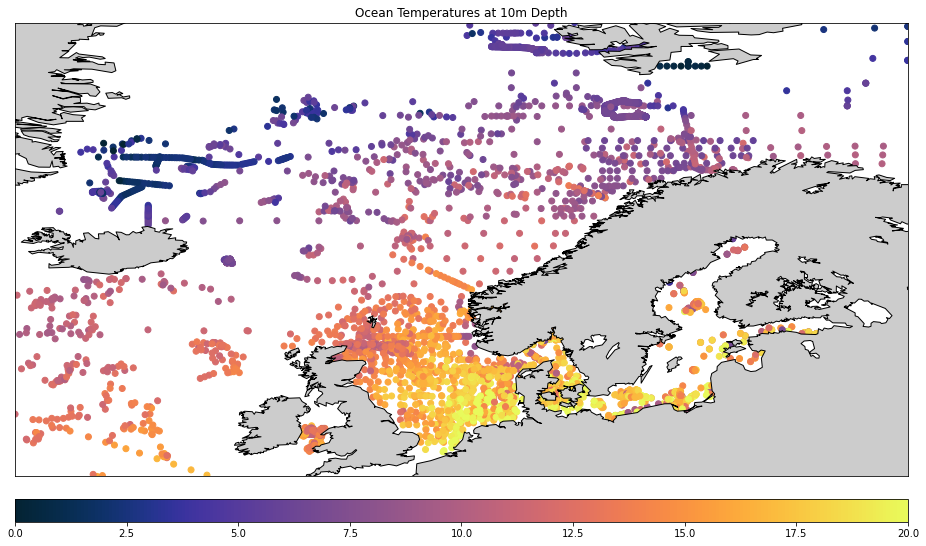

In [61]:
plot_casts('Temperature',df_surf,cmap=cmocean.cm.thermal,vrange=[0,20]);plt.title('Ocean Temperatures at 10m Depth')

## Ocean summer temperature gridding 2D (longitude,latitude)

In [62]:

points=df_surf[['lon','lat']].values.astype('float')
values=df_surf['Temperature'].values.astype('float')


int_points=[np.linspace(-25,35,60*10+1),np.linspace(50,80,30*10+1)]


###  Inverse Distance Interpolation - Cressman

Text(0.5, 1.0, 'cressman')

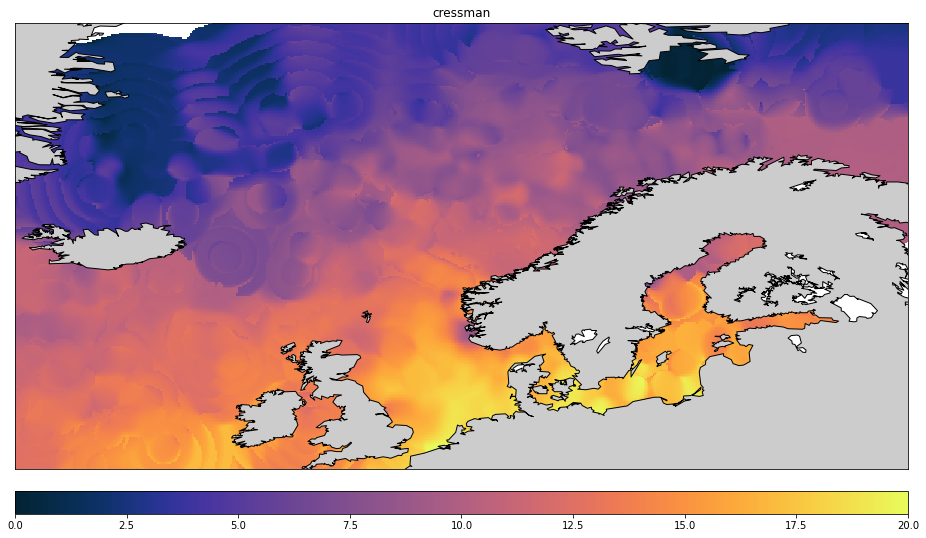

In [63]:
kind='cressman'
g=np.ones(int_lon.shape)*np.nan
for i,r in enumerate([7,5,4,3,2,1]):
    
    grid,_g=inerpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type=kind, minimum_neighbors=3,
                          search_radius=r,rescale=False)

       
    g[~np.isnan(_g)]=_g[~np.isnan(_g)]
    
plot_grid(grid[0],grid[1],g,cmap=cmocean.cm.thermal,vrange=[0,20])
plt.title(kind)

###  Inverse Distance Interpolation - Barnes

Text(0.5, 1.0, 'barnes')

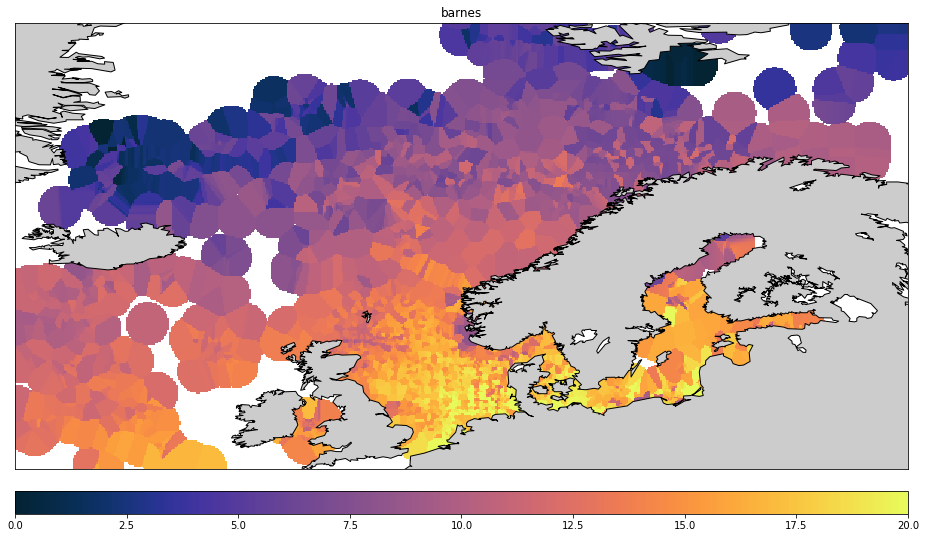

In [64]:
kind='barnes'

g=np.ones(int_lon.shape)*np.nan
for i,r in enumerate([7,5,4,3,2,1]):
    
    grid,_g=inerpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type=kind, minimum_neighbors=3,
                          search_radius=r,rescale=False)
 
    g[~np.isnan(_g)]=_g[~np.isnan(_g)]
    
plot_grid(grid[0],grid[1],g,cmap=cmocean.cm.thermal,vrange=[0,20])
plt.title(kind)

### Radial Basis Function (RBF)

Text(0.5, 1.0, 'rbf')

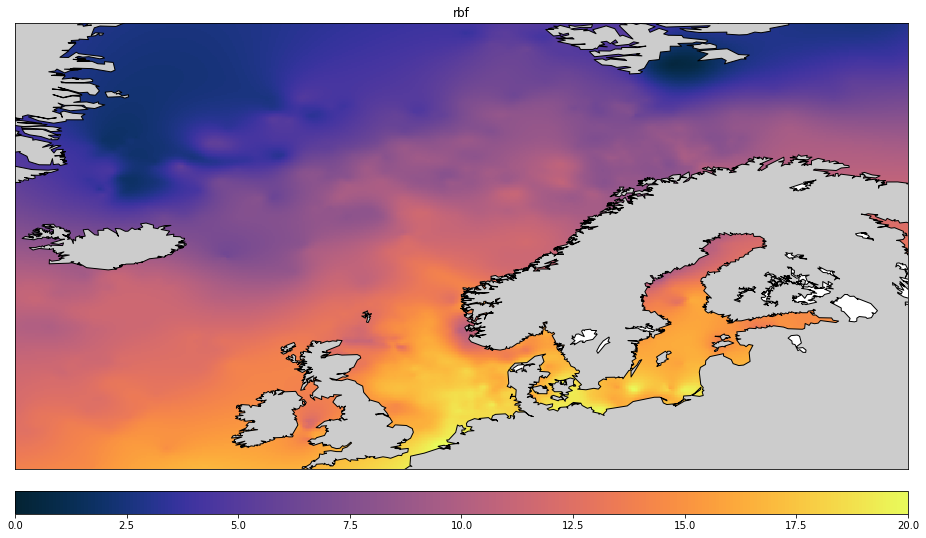

In [65]:
kind='rbf'
grid,g=inerpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type=kind,
                               rbf_func='linear',rbf_smooth=0.1,rescale=True)
plot_grid(grid[0],grid[1],g,cmap=cmocean.cm.thermal,vrange=[0,20])
plt.title(kind)

## Ocean temperature gridding 3D (longitude,latitude and time)

In [66]:
    
df_surf['unixtime']=df_surf['datetime'].apply(lambda x : x.value) 
df_surf.dropna(inplace=True)
points=df_surf[['lon','lat','unixtime']].values.astype('float')
values=df_surf['Temperature'].values .astype('float')

int_points=[np.linspace(-25,35,60*4+1),np.linspace(50,80,30*4+1),np.linspace(pd.Timestamp('2018-06-01').value,pd.Timestamp('2018-08-31').value,8)]
    
    

## Linear Interpolation 3D

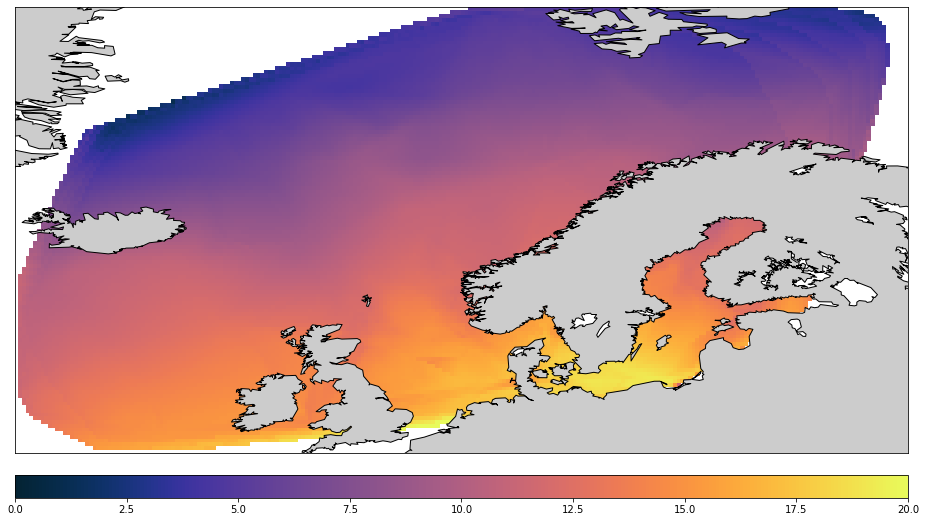

In [67]:
grid,g=inerpolate_to_grid(points.copy(),values.copy(),int_points.copy(), interp_type='linear',rescale=True)

plot_grid(grid[0][:,:,0],grid[1][:,:,0],np.nanmean(g[:,:],axis=2),cmap=cmocean.cm.thermal,vrange=[0,20])#;plt.title(interp_type)
